In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


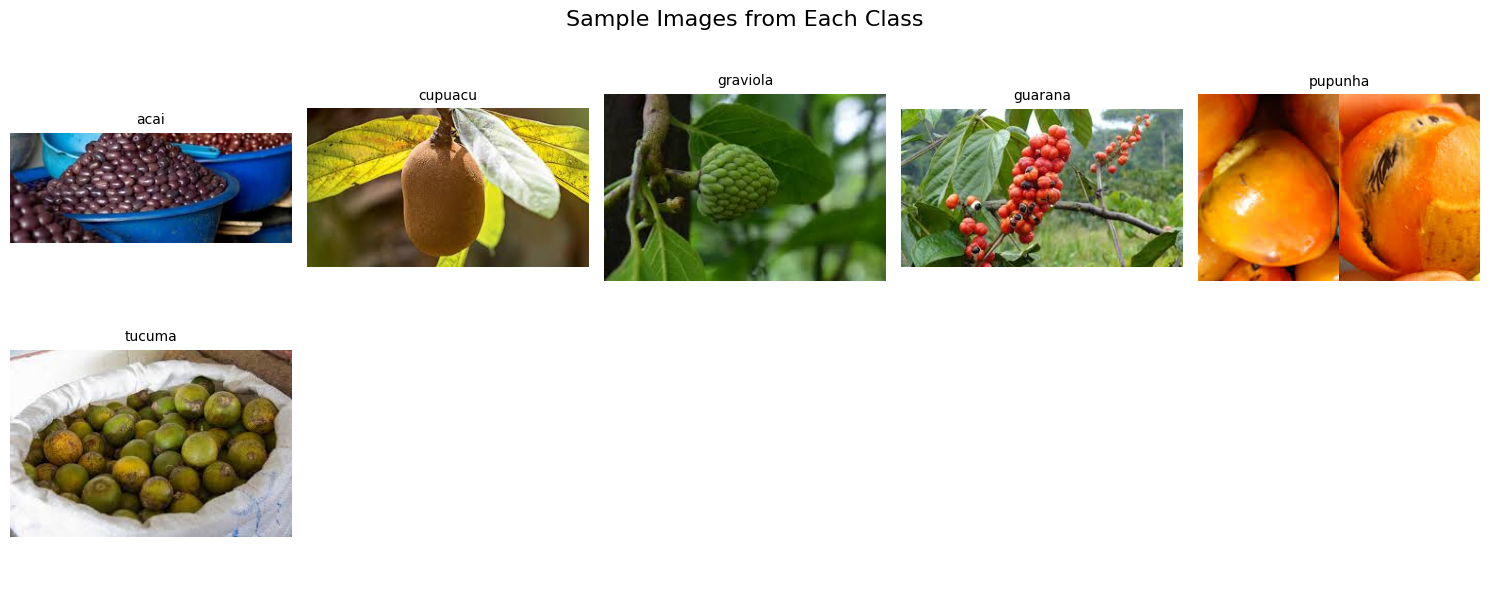

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/AI2/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/AI2/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [4]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'Rijan Manandhar.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.1250 - loss: 1.8585
Epoch 1: val_loss improved from inf to 1.53407, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.1250 - loss: 1.8690 - val_accuracy: 0.8333 - val_loss: 1.5341
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2234 - loss: 1.7018
Epoch 2: val_loss improved from 1.53407 to 1.32818, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step - accuracy: 0.2335 - loss: 1.6985 - val_accuracy: 0.7778 - val_loss: 1.3282
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4346 - loss: 1.4378
Epoch 3: val_loss did not improve from 1.32818
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.4371 - loss: 1.4366 - val_accuracy: 0.1111 - val_loss: 2.8173
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2575 - loss: 2.0235
Epoch 4: val_loss improved from 1.32818 to 1.30479, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - accuracy: 0.2730 - loss: 1.9695 - val_accuracy: 0.4444 - val_loss: 1.3048
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8154 - loss: 1.1247
Epoch 5: val_loss improved from 1.30479 to 1.00038, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - accuracy: 0.8129 - loss: 1.1204 - val_accuracy: 0.8889 - val_loss: 1.0004
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7749 - loss: 0.8599
Epoch 6: val_loss did not improve from 1.00038
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - accuracy: 0.7756 - loss: 0.8576 - val_accuracy: 0.5556 - val_loss: 1.3599
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7645 - loss: 0.7272
Epoch 7: val_loss did not improve from 1.00038
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.7678 - loss: 0.7225 - val_accuracy: 0.6667 - val_loss: 1.1422
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7483 - loss: 0.6619
Epoch 8: val_loss improved from 1.00038 to 0.77763, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.7591 - loss: 0.6499 - val_accuracy: 0.8333 - val_loss: 0.7776
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9497 - loss: 0.3798
Epoch 9: val_loss improved from 0.77763 to 0.59031, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.9518 - loss: 0.3760 - val_accuracy: 0.7778 - val_loss: 0.5903
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9392 - loss: 0.2340
Epoch 10: val_loss did not improve from 0.59031
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.9440 - loss: 0.2292 - val_accuracy: 0.6111 - val_loss: 0.7868
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9797 - loss: 0.1489
Epoch 11: val_loss improved from 0.59031 to 0.40322, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.9813 - loss: 0.1449 - val_accuracy: 0.8889 - val_loss: 0.4032
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 1.0000 - loss: 0.0850
Epoch 12: val_loss did not improve from 0.40322
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - accuracy: 1.0000 - loss: 0.0828 - val_accuracy: 0.8889 - val_loss: 0.4169
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 1.0000 - loss: 0.0428
Epoch 13: val_loss improved from 0.40322 to 0.36355, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 1.0000 - loss: 0.0422 - val_accuracy: 0.8889 - val_loss: 0.3635
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 1.0000 - loss: 0.0212
Epoch 14: val_loss improved from 0.36355 to 0.35884, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 1.0000 - loss: 0.0211 - val_accuracy: 0.8889 - val_loss: 0.3588
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 1.0000 - loss: 0.0143
Epoch 15: val_loss did not improve from 0.35884
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8889 - val_loss: 0.3993
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 1.0000 - loss: 0.0123
Epoch 16: val_loss did not improve from 0.35884
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.8889 - val_loss: 0.3654
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 17: val_loss improved from 0.35884 to 0.35333, saving model to Rijan Manandhar.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.8889 - val_loss: 0.3533
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 18: val_loss did not improve from 0.35333
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8889 - val_loss: 0.3811
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 19: val_loss did not improve from 0.35333
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.8889 - val_loss: 0.3993
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 20: val_loss did not improve from 0.35333
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8889 - val_loss: 0.3970
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 21: val_loss did not improve from 0.35333
3/3 

In [8]:
test_dir = '/content/drive/MyDrive/AI2/FruitinAmazon/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7000 - loss: 197.9894
Test Loss: 197.98939514160156
Test Accuracy: 0.699999988079071


In [9]:

model.save('Rijan_Manandhar_model.h5')
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.44      0.80      0.57         5
           2       0.83      1.00      0.91         5
           3       0.67      0.80      0.73         5
           4       1.00      0.60      0.75         5
           5       1.00      0.40      0.57         5

    accuracy                           0.70        30
   macro avg       0.78      0.70      0.70        30
weighted avg       0.78      0.70      0.70        30

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 1: val_loss did not improve from 0.35333
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 879ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.8889 - val_loss: 0.3684
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0043
Epoch 2: val_loss did not improve from 0.35333
3/3 ━━━━━━━━━━━━━━━

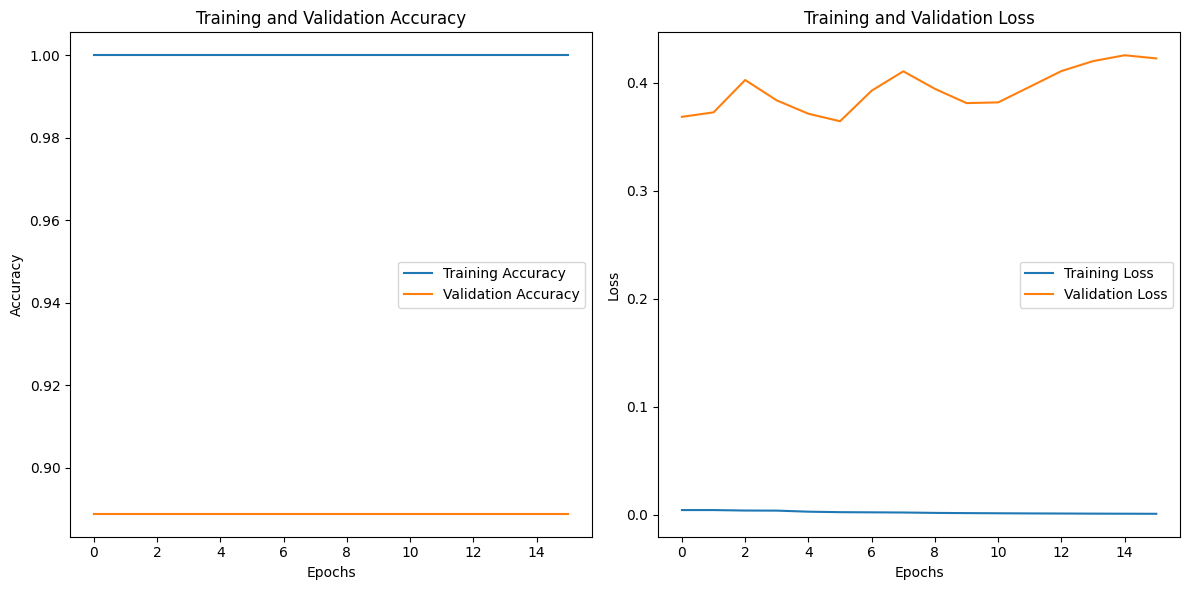

Model saved as 'shreejal_khatri_model.h5'


In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('Rijan_Manandhar__model.h5')
print("Model saved as 'shreejal_khatri_model.h5'")


## Task 1: Improved Model with Data Augmentation, Batch Normalization, and Dropout

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,822 (6.21 MB)

 Trainable params: 1,626,374 (6.20 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2264 - loss: 2.6687 - val_accuracy: 0.2667 - val_loss: 1.7394
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 733ms/step - accuracy: 0.3707 - loss: 1.6965 - val_accuracy: 0.3444 - val_loss: 1.6131
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 965ms/step - accuracy: 0.5773 - loss: 1.1686 - val_accuracy: 0.5667 - val_loss: 1.5415
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step - accuracy: 0.5809 - loss: 1.2965 - val_accuracy: 0.5111 - val_loss: 1.5420
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 722ms/step - accuracy: 0.5518 - loss: 1.3219 - val_accuracy: 0.2111 - val_loss: 1.6397
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.6487 - loss: 0.9861 - val_accuracy: 0.1778 - val_loss: 1.7592
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 913ms/step - accuracy: 0.6633 - loss: 1.0550 - val_accuracy: 0.1778 - val_loss: 1.8181
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - accuracy: 0.5478 - loss: 1.1387 - val_accuracy: 0.1778 - val_loss: 1.

## Task 2: Transfer Learning using VGG16

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

train_generator_vgg = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator_vgg = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI2/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Train the model
history_vgg = model.fit(train_generator_vgg, epochs=5, validation_data=val_generator_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 120s 46s/step - accuracy: 0.2039 - loss: 1.9129 - val_accuracy: 0.3778 - val_loss: 1.6588
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 47s/step - accuracy: 0.3346 - loss: 1.6903 - val_accuracy: 0.5222 - val_loss: 1.4255
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 47s/step - accuracy: 0.5276 - loss: 1.4524 - val_accuracy: 0.6222 - val_loss: 1.2851
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 142s 46s/step - accuracy: 0.6514 - loss: 1.3119 - val_accuracy: 0.7444 - val_loss: 1.1289
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 139s 59s/step - accuracy: 0.6269 - loss: 1.2226 - val_accuracy: 0.6889 - val_loss: 1.0646


In [14]:
#Report
import numpy as np
from sklearn.metrics import classification_report


Y_pred = model.predict(val_generator_vgg)
y_pred = np.argmax(Y_pred, axis=1)
print("Classification Report:")
print(classification_report(val_generator_vgg.classes, y_pred, target_names=list(val_generator_vgg.class_indices.keys())))


3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 19s/step
Classification Report:
              precision    recall  f1-score   support

        acai       0.31      0.27      0.29        15
     cupuacu       0.12      0.13      0.13        15
    graviola       0.15      0.27      0.19        15
     guarana       0.12      0.07      0.09        15
     pupunha       0.00      0.00      0.00        15
      tucuma       0.08      0.13      0.10        15

    accuracy                           0.14        90
   macro avg       0.13      0.14      0.13        90
weighted avg       0.13      0.14      0.13        90

